# **EDA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/Detección de puertas y ventanas /DoorAndWindowDetectionDataset" .


In [ ]:
!ls DoorAndWindowDetectionDataset


data.yaml  README.txt  test  train  valid


In [ ]:
import os
import glob
import yaml
import matplotlib.pyplot as plt
from collections import Counter
import random
from PIL import Image, ImageDraw


Cargar configuración del dataset (data.yaml)

In [ ]:
dataset_path = "DoorAndWindowDetectionDataset"

with open(os.path.join(dataset_path, "data.yaml"), "r") as f:
    data = yaml.safe_load(f)

names = data["names"]
names


['door', 'window']

Función para leer anotaciones YOLO

In [ ]:
def read_yolo_labels(label_file):
    objects = []
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            bbox = list(map(float, parts[1:]))
            objects.append((cls, bbox))
    return objects


Contar cuántas puertas y ventanas hay en total

In [ ]:
label_dirs = [
    os.path.join(dataset_path, "train/labels"),
    os.path.join(dataset_path, "valid/labels"),
    os.path.join(dataset_path, "test/labels"),
]

class_counts = Counter()

for ld in label_dirs:
    for file in glob.glob(ld + "/*.txt"):
        objs = read_yolo_labels(file)
        for cls, _ in objs:
            class_counts[cls] += 1

class_counts


Counter({1: 11150, 0: 1312})

Visualizar distribución de clases

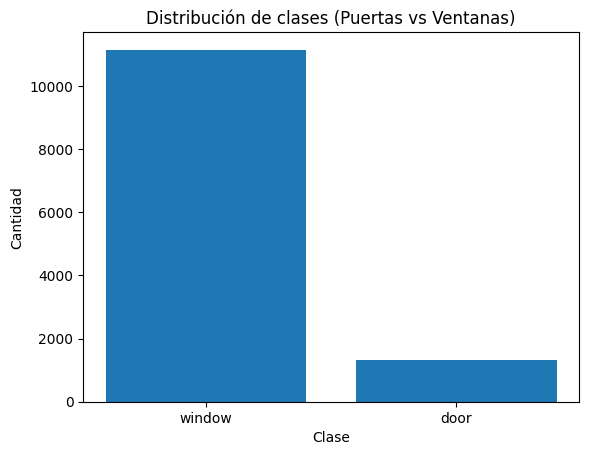

In [ ]:
plt.bar([names[k] for k in class_counts.keys()], class_counts.values())
plt.title("Distribución de clases (Puertas vs Ventanas)")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()


Dataset muy desbalanceado, con casi 9 veces más ventanas que puertas. Este desbalance puede afectar el rendimiento del modelo en la clase minoritaria (puertas).

Objetos por imagen

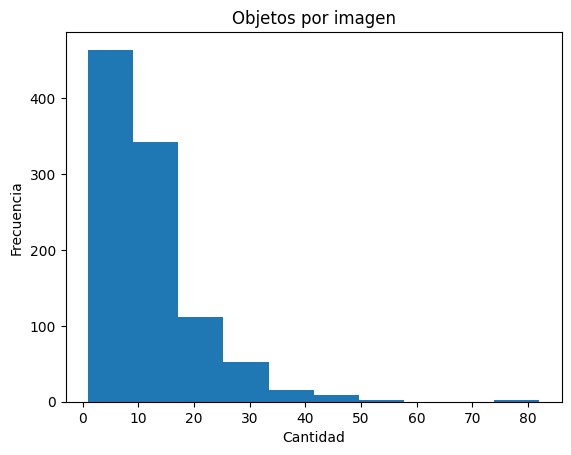

In [ ]:
objects_per_image = []

for ld in label_dirs:
    for file in glob.glob(ld + "/*.txt"):
        objs = read_yolo_labels(file)
        objects_per_image.append(len(objs))

plt.hist(objects_per_image, bins=10)
plt.title("Objetos por imagen")
plt.xlabel("Cantidad")
plt.ylabel("Frecuencia")
plt.show()


Histograma sesgado hacia la izquierda, lo que significa que:
- La mayoría de las imágenes tienen pocos objetos (entre 1 y 10).
- Hay algunas imágenes con muchos objetos (hasta 40 o más), pero son menos frecuentes.


> Esto sugiere que el dataset tiene una buena variedad de densidad visual, pero la mayoría de las imágenes son relativamente simples.


Distribución de tamaños de bounding boxes

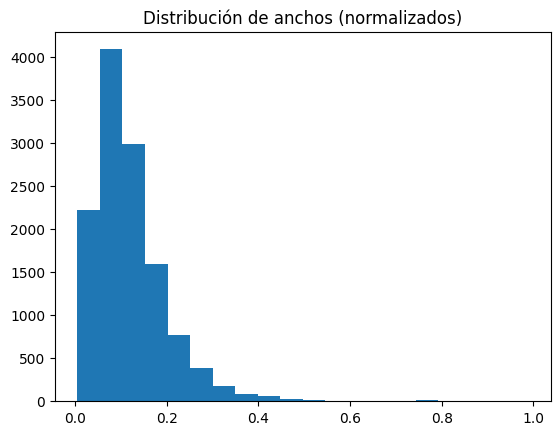

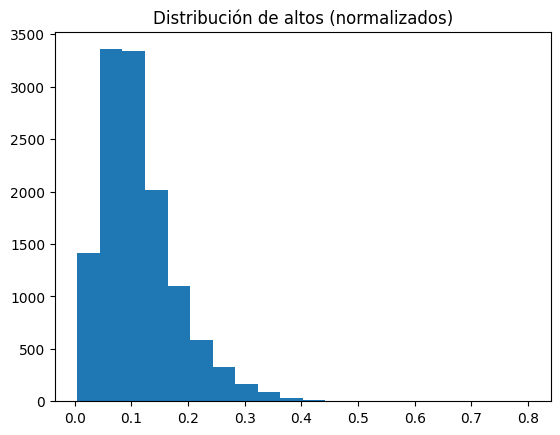

In [ ]:
widths = []
heights = []

for ld in label_dirs:
    for file in glob.glob(ld + "/*.txt"):
        objs = read_yolo_labels(file)
        for _, bbox in objs:
            widths.append(bbox[2])
            heights.append(bbox[3])

plt.hist(widths, bins=20)
plt.title("Distribución de anchos (normalizados)")
plt.show()

plt.hist(heights, bins=20)
plt.title("Distribución de altos (normalizados)")
plt.show()


- Anchos normalizados:
  - La mayoría de los objetos tienen un ancho entre 0.05 y 0.3 (en escala normalizada).
  - Muy pocos objetos tienen anchos grandes (>0.5).

- Altos normalizados:
  - La mayoría de los objetos tienen una altura entre 0.05 y 0.15.
  - Muy pocos objetos son altos (>0.4).

> Esto indica que la mayoría de las puertas y ventanas son pequeñas en relación al tamaño de la imagen, lo cual es típico en imágenes de fachadas completas.
Es importante porque objetos pequeños pueden ser más difíciles de detectar, especialmente si hay ruido visual o baja resolución.

Detectar imágenes sin anotaciones

In [ ]:
missing = []

for split in ["train", "valid", "test"]:
    img_dir = os.path.join(dataset_path, split, "images")
    label_dir = os.path.join(dataset_path, split, "labels")

    for img in glob.glob(img_dir + "/*"):
        base = os.path.splitext(os.path.basename(img))[0]
        label = os.path.join(label_dir, base + ".txt")
        if not os.path.exists(label):
            missing.append(img)

missing[:10], len(missing)


([], 0)

Visualizar ejemplos anotados

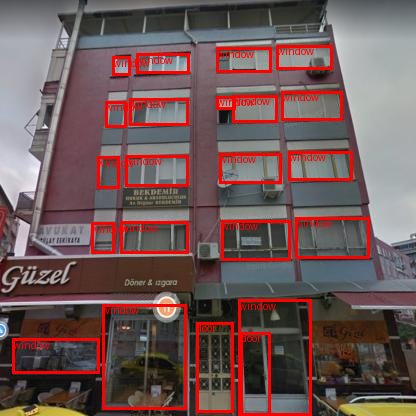

In [ ]:
def show_random_annotated(split="train"):
    img_dir = os.path.join(dataset_path, split, "images")
    label_dir = os.path.join(dataset_path, split, "labels")

    img_files = glob.glob(img_dir + "/*")
    img_file = random.choice(img_files)

    base = os.path.splitext(os.path.basename(img_file))[0]
    label_file = os.path.join(label_dir, base + ".txt")

    img = Image.open(img_file)
    draw = ImageDraw.Draw(img)

    if os.path.exists(label_file):
        objs = read_yolo_labels(label_file)
        w, h = img.size

        for cls, bbox in objs:
            xc, yc, bw, bh = bbox
            x1 = (xc - bw/2) * w
            y1 = (yc - bh/2) * h
            x2 = (xc + bw/2) * w
            y2 = (yc + bh/2) * h

            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
            draw.text((x1, y1), names[cls], fill="red")

    return img

show_random_annotated("train")


Resumen final del dataset

In [ ]:
print("Total puertas:", class_counts[0])
print("Total ventanas:", class_counts[1])

total = class_counts[0] + class_counts[1]
print("Proporción puertas:", class_counts[0] / total)
print("Proporción ventanas:", class_counts[1] / total)

print("Promedio de objetos por imagen:", sum(objects_per_image) / len(objects_per_image))


Total puertas: 1312
Total ventanas: 11150
Proporción puertas: 0.10528005135612262
Proporción ventanas: 0.8947199486438774
Promedio de objetos por imagen: 12.462


# **SEGUNDA PARTE**

In [ ]:
output_dir = "/content/drive/MyDrive/Detección de puertas y ventanas "



In [ ]:
import os

os.makedirs(os.path.join(output_dir, "door"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "window"), exist_ok=True)


Función para recortar objetos

In [ ]:
from PIL import Image

def recortar_objetos(img_path, label_path, output_dir):
    img = Image.open(img_path)
    w, h = img.size

    with open(label_path, "r") as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        cls, xc, yc, bw, bh = map(float, line.split())
        cls = int(cls)

        # Convertir coordenadas YOLO a píxeles
        x1 = int((xc - bw/2) * w)
        y1 = int((yc - bh/2) * h)
        x2 = int((xc + bw/2) * w)
        y2 = int((yc + bh/2) * h)

        # Recorte
        recorte = img.crop((x1, y1, x2, y2))

        # Guardar
        clase_nombre = names[cls]
        filename = os.path.basename(img_path).replace(".jpg", f"_{i}.jpg")
        recorte.save(os.path.join(output_dir, clase_nombre, filename))


Aplicar recorte a TODO el dataset

In [ ]:
splits = ["train", "valid", "test"]

for split in splits:
    img_dir = os.path.join(dataset_path, split, "images")
    label_dir = os.path.join(dataset_path, split, "labels")

    for img_path in glob.glob(img_dir + "/*"):
        base = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(label_dir, base + ".txt")

        if os.path.exists(label_path):
            recortar_objetos(img_path, label_path, output_dir)


In [ ]:
print("Puertas recortadas:", len(os.listdir("recortes/door")))
print("Ventanas recortadas:", len(os.listdir("recortes/window")))


Puertas recortadas: 947
Ventanas recortadas: 8106
